In [1]:
import os
import numpy as np
import json
import cv2
import random
import matplotlib.pyplot as plt
import torch
import time
import datetime
import logging

from pycocotools.coco import COCO

from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor

#Visualize
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
# Training part
import sys
sys.path.append('/home/josmar/proyectos/centermask2')

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import build_detection_test_loader
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import  default_setup
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.evaluation import inference_context
from centermask.config import get_cfg
from train_net import Trainer
import wandb 



In [2]:
# for d in ["train", "val"]:
for d in ["train", "val","test"]:
    register_coco_instances("ucb_gait_{}".format(d), {}, 
                            "/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/{}_reordered_ucb-gait_crop.json".format(d),
                            "/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images")
                            # "/home/josmar/proyectos/codes/datasets/lvis/lvis_v1_{}_cocofied.json".format(d),
                            # "/home/josmar/proyectos/codes/datasets/coco/train2017")

                            # "/home/josmar/proyectos/codes/datasets/ochumans/ochuman_coco_format_{}_range_0.00_1.00.json".format(d),
                            # "/home/josmar/proyectos/codes/datasets/ochumans/images")
    MetadataCatalog.get("ucb_gait_" + d).set(thing_classes=["person"])
ucb_gait_metadata = MetadataCatalog.get("ucb_gait_train")
print(ucb_gait_metadata)

dataset_dicts = DatasetCatalog.get("ucb_gait_train")

Metadata(evaluator_type='coco', image_root='/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images', json_file='/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/train_reordered_ucb-gait_crop.json', name='ucb_gait_train', thing_classes=['person'])


/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images/crop_019-238.jpg


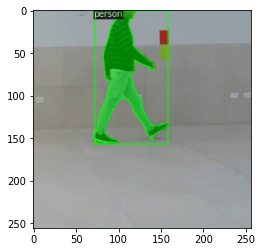

/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images/crop_043-213.jpg


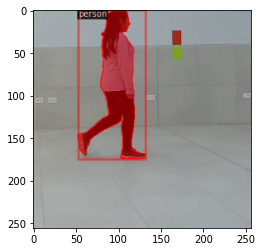

/home/josmar/proyectos/codes/datasets/ucb_gait_cropped/images/crop_039-201.jpg


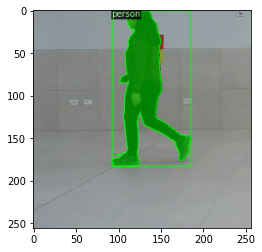

In [3]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ucb_gait_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.imshow(vis.get_image())
    plt.show()

In [4]:


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [5]:

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [6]:
def beep(duration, freq):
    os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

In [7]:

def set_training(custom_cfg, out_dir):
    
    cfg = get_cfg()
    cfg.merge_from_file(custom_cfg.model)
    cfg.DATASETS.TRAIN = (custom_cfg.train_dataset,)

    cfg.DATASETS.TEST = (custom_cfg.val_dataset,)  # no metrics implemented for this dataset
    cfg.TEST.EVAL_PERIOD = custom_cfg.eval_it

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = custom_cfg.weights  # initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = custom_cfg.lr  # pick a good LR
    cfg.SOLVER.MAX_ITER = custom_cfg.max_it   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
    cfg.MODEL.FCOS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.FCOS.NUM_CLASSES = 1  # only has one class (ballon)

    cfg.OUTPUT_DIR = out_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = MyTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    
    return trainer, cfg

In [8]:
def metrics2dict(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

In [9]:

def predict_masks(cfg, test_dicts, n_images):
    

    predictor = DefaultPredictor(cfg)


    class_labels = {
    1: "person 1",
    2: "person 2",
    3: "person 3"
    }

    

    wandb_masks = []
    for d in random.sample(test_dicts, n_images):
            
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)

        rgb_im = im[:, :, ::-1]

        mask= outputs['instances'].get('pred_masks')
        mask= mask.to('cpu')
        num, h, w= mask.shape
        bin_mask= np.zeros((h, w))

        idx = 1  
        for m in mask:
            sil = m.numpy()
            av_mask = bin_mask == 0 # Gets the pixels that are not used 
            corrected_sil = gen = np.bitwise_and(av_mask, sil) #Gets the silhouette cropping the overlapped parts
            bin_mask+= corrected_sil * idx
            idx +=1
        
        wandb_img = wandb.Image(rgb_im, masks={
        "prediction" : {"mask_data" : bin_mask, "class_labels" : class_labels}})
        wandb_masks.append(wandb_img)

    return wandb_masks
    

In [10]:

def predict_images(cfg, test_dicts, n_images):
    predictor = DefaultPredictor(cfg)
    class_labels = {
    1: "person 1",
    2: "person 2",
    3: "person 3"
    }
    wandb_imgs = []
    for d in random.sample(test_dicts, n_images):       
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        rgb_im = im[:, :, ::-1]
        # masks init
        masks= outputs['instances'].get('pred_masks')
        masks= masks.to('cpu')
        num, h, w= masks.shape
        bin_mask= np.zeros((h, w))

        # boxes init
        boxes = outputs['instances'].get('pred_boxes')
        boxes = boxes.to('cpu')
        box_data = []

        # scores init
        scores = outputs['instances'].get('scores')
        scores = scores.to('cpu')

        idx = 0
        for b in boxes:
            # masks
            sil = masks[idx].numpy()
            av_mask = bin_mask == 0 # Gets the pixels that are not used 
            corrected_sil = gen = np.bitwise_and(av_mask, sil) #Gets the silhouette cropping the overlapped parts
            bin_mask+= corrected_sil * (idx+1)

            #scores
            acc = scores[idx].numpy()
            acc = round(float(acc), 2)

            #boxes
            print(boxes[idx])
            x_min, y_min, x_max, y_max = b.numpy()
            h,w,_ = im.shape
            x_min, x_max = round(x_min/w, 2), round(x_max/w, 2)
            y_min, y_max = round(y_min/h, 2), round(y_max/h, 2)

            bbox_dict = {"position": {
                            "minX": x_min,
                            "maxX": x_max,
                            "minY": y_min,
                            "maxY": y_max},
                        "class_id" : idx+1,
                        "box_caption": "person:{}".format(acc),
                        "scores" : {
                            "acc": acc},
                        }
            box_data.append(bbox_dict)
            idx+=1

        
        plt.imshow(bin_mask)
        plt.show()
        plt.imshow(rgb_im)
        plt.show()
        wandb_img = wandb.Image(rgb_im, 
        masks={"prediction" : {"mask_data" : bin_mask, "class_labels" : class_labels}},
        boxes={"prediction" : {"box_data" : box_data, "class_labels" : class_labels}})
        
        wandb_imgs.append(wandb_img)
        
    return wandb_imgs    

In [11]:

def evaluate_ap(cfg, dataset):
    print("COCOEvaluator")
    evaluator = COCOEvaluator(dataset, cfg, False, output_dir=cfg.OUTPUT_DIR)
    print("Val loader")
    val_loader = build_detection_test_loader(cfg, dataset)
    print("Inference on dataset")
    trainer = MyTrainer(cfg) 
    trainer.resume_or_load(resume=True)
    test_eval = inference_on_dataset(trainer.model, val_loader, evaluator)
    return test_eval

In [12]:
def upload_training(metrics_path):
    metrics = metrics2dict(metrics_path)

    iterations = [x['iteration'] for x in metrics if 'total_loss' in x] 
    losses = [x['total_loss'] for x in metrics if 'total_loss' in x]

    for idx in range(len(iterations)):
        wandb.log({"total_loss": losses[idx],"iter":iterations[idx]})


    val_iters = [x['iteration'] for x in metrics if 'validation_loss' in x]

    val_losses = [x['validation_loss'] for x in metrics if 'validation_loss' in x]
    val_box_ap = [x['bbox/AP'] for x in metrics if 'bbox/AP' in x]
    val_segm_ap = [x['segm/AP'] for x in metrics if 'segm/AP' in x]
    for idx in range(len(val_iters)):
        wandb.log({"val_loss": val_losses[idx],
                    "iter":val_iters[idx],
                    "val_ap_box": val_box_ap[idx],
                    "val_ap_segm": val_segm_ap[idx]
                    })


def start_run(custom_cfg):

    # Training
    trainer, cfg = set_training(custom_cfg)

    trainer.train()
    beep(1,440)

    # Training curves
    metrics_path = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
    upload_training(metrics_path)
    # metrics_path = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
    # metrics = metrics2dict(metrics_path)
    # wandb.log({"Training": metrics})

    # Evaluation: Masking test_images
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.FCOS.SCORE_THRESH_TEST = custom_cfg.test_th   # set the testing threshold for this model
    cfg.MODEL.FCOS.INFERENCE_TH_TEST = custom_cfg.test_th
    cfg.DATASETS.TEST = (custom_cfg.test_dataset, )
    test_dicts = DatasetCatalog.get(custom_cfg.test_dataset)
    predicted_masks = predict_images(cfg=cfg, test_dicts=test_dicts, n_images = 3)


    # Evaluation: Predicting test AP

    test_eval = evaluate_ap(cfg, custom_cfg.test_dataset)

    # Saving evaluation results in wandb
    wandb.log({"predictions" : predicted_masks})
    wandb.log(test_eval)
    

my_config = {
    "lr": 0.00025,
    "max_it" : 2000,
    "eval_it" : 500,
    "classes" : 1,
    "model" : "/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml",
    "weights" : "/home/josmar/proyectos/centermask2/weights/centermask2-lite-V-39-eSE-FPN-ms-4x.pth",
    "train_dataset" : "ucb_gait_train",
    "val_dataset" : "ucb_gait_val",
    "test_dataset" : "ucb_gait_test",
    "test_th" : 0.4,
    "out_dir" : "./new_runs/run15"
    }

wandb.init(project="instance_segmentation_train")

# Define hyperparameters
config = wandb.config           # for shortening
config.framework = "pytorch"
config.update(my_config)
config.out_dir = "./new_runs/{}".format(wandb.run.name)

start_run(config)

wandb.run.finish()

In [2]:
import pprint
import math

#Configurate sweeps

sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'total_loss',
    'goal': 'minimize'   
    }

parameters_dict = {
    'lr': {
        # a flat distribution between 0 and 0.1
        'values': [0.001, 0.0025, 0.0001, 0.00025]},
    
    "max_it" :{"value": 2000},
    "eval_it" : {"value": 500},
    "classes" : {"value":1},
    "model" : {"value":"/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml"},
    "weights" : {"value":"/home/josmar/proyectos/centermask2/weights/centermask2-lite-V-39-eSE-FPN-ms-4x.pth"},
    "train_dataset" : {"value":"ucb_gait_train"},
    "val_dataset" : {"value":"ucb_gait_val"},
    "test_dataset" : {"value":"ucb_gait_test"},
    "test_th" : {"value":0.4},
    "out_dir" : {"value":"./new_runs/run15"}
    }
    

sweep_config['metric'] = metric
sweep_config['parameters'] = parameters_dict

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'total_loss'},
 'parameters': {'classes': {'value': 1},
                'eval_it': {'value': 500},
                'lr': {'values': [0.001, 0.0025, 0.0001, 0.00025]},
                'max_it': {'value': 2000},
                'model': {'value': '/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml'},
                'out_dir': {'value': './new_runs/run15'},
                'test_dataset': {'value': 'ucb_gait_test'},
                'test_th': {'value': 0.4},
                'train_dataset': {'value': 'ucb_gait_train'},
                'val_dataset': {'value': 'ucb_gait_val'},
                'weights': {'value': '/home/josmar/proyectos/centermask2/weights/centermask2-lite-V-39-eSE-FPN-ms-4x.pth'}}}


In [3]:
sweep_id = wandb.sweep(sweep_config, project="instance_segmentation_train")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Create sweep with ID: 3s05ee8x
Sweep URL: https://wandb.ai/josmar4321/instance_segmentation_train/sweeps/3s05ee8x


In [19]:
def sweep_run(custom_cfg = None):
    with wandb.init(config=custom_cfg):

        custom_cfg = wandb.config
        # Training
        out_dir = "./new_runs/{}".format(wandb.run.name)
        trainer, cfg = set_training(custom_cfg, out_dir)

        trainer.train()
        beep(1,440)

        # Training curves
        metrics_path = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
        upload_training(metrics_path)
        # metrics_path = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
        # metrics = metrics2dict(metrics_path)
        # wandb.log({"Training": metrics})

        # Evaluation: Masking test_images
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
        cfg.MODEL.FCOS.SCORE_THRESH_TEST = custom_cfg.test_th   # set the testing threshold for this model
        cfg.MODEL.FCOS.INFERENCE_TH_TEST = custom_cfg.test_th
        cfg.DATASETS.TEST = (custom_cfg.test_dataset, )
        test_dicts = DatasetCatalog.get(custom_cfg.test_dataset)
        predicted_masks = predict_images(cfg=cfg, test_dicts=test_dicts, n_images = 3)


        # Evaluation: Predicting test AP

        test_eval = evaluate_ap(cfg, custom_cfg.test_dataset)

        # Saving evaluation results in wandb
        wandb.log({"predictions" : predicted_masks})
        wandb.log(test_eval)

In [16]:
wandb.agent(sweep_id, sweep_run, count=3)

wandb: Agent Starting Run: kq87c605 with config:
wandb: 	classes: 1
wandb: 	eval_it: 500
wandb: 	lr: -9.153954229142762
wandb: 	max_it: 2000
wandb: 	model: /home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml
wandb: 	out_dir: ./new_runs/run15
wandb: 	test_dataset: ucb_gait_test
wandb: 	test_th: 0.4
wandb: 	train_dataset: ucb_gait_train
wandb: 	val_dataset: ucb_gait_val
wandb: 	weights: /home/josmar/proyectos/centermask2/weights/centermask2-lite-V-39-eSE-FPN-ms-4x.pth
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: josmar4321 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Config '/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[01/18 17:57:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): VoVNet(
      (stem): Sequential(
        (stem_1/conv): Conv2d

Run kq87c605 errored: ValueError('Invalid learning rate: -9.153954229142762',)
wandb: ERROR Run kq87c605 errored: ValueError('Invalid learning rate: -9.153954229142762',)
wandb: Agent Starting Run: cqq8ctx3 with config:
wandb: 	classes: 1
wandb: 	eval_it: 500
wandb: 	lr: -9.179185896440492
wandb: 	max_it: 2000
wandb: 	model: /home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml
wandb: 	out_dir: ./new_runs/run15
wandb: 	test_dataset: ucb_gait_test
wandb: 	test_th: 0.4
wandb: 	train_dataset: ucb_gait_train
wandb: 	val_dataset: ucb_gait_val
wandb: 	weights: /home/josmar/proyectos/centermask2/weights/centermask2-lite-V-39-eSE-FPN-ms-4x.pth
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


WARNING [01/18 17:57:46 d2.config.compat]: Config '/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[01/18 17:57:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): VoVNet(
      (stem)

Run cqq8ctx3 errored: ValueError('Invalid learning rate: -9.179185896440492',)
wandb: ERROR Run cqq8ctx3 errored: ValueError('Invalid learning rate: -9.179185896440492',)
wandb: Agent Starting Run: ezutadn5 with config:
wandb: 	classes: 1
wandb: 	eval_it: 500
wandb: 	lr: -9.885331218348592
wandb: 	max_it: 2000
wandb: 	model: /home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml
wandb: 	out_dir: ./new_runs/run15
wandb: 	test_dataset: ucb_gait_test
wandb: 	test_th: 0.4
wandb: 	train_dataset: ucb_gait_train
wandb: 	val_dataset: ucb_gait_val
wandb: 	weights: /home/josmar/proyectos/centermask2/weights/centermask2-lite-V-39-eSE-FPN-ms-4x.pth
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


WARNING [01/18 17:57:54 d2.config.compat]: Config '/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[01/18 17:57:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): VoVNet(
      (stem)

Run ezutadn5 errored: ValueError('Invalid learning rate: -9.885331218348592',)
wandb: ERROR Run ezutadn5 errored: ValueError('Invalid learning rate: -9.885331218348592',)
Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true
